In [1]:
import numpy as np

def DSG_Hamiltonian(order: int=2, gamma: float=1.) -> np.ndarray:
    
    size = 3**order
    A = np.zeros((size, size))
    
    for i in [n+1 for n in range(order)]:
        for j in range(int(size/(3**i))):
            a1 = np.floor((j*9 + 0*3 + 1) * 3**(i-2)).astype(int)
            a2 = np.floor((j*9 + 1*3 + 2) * 3**(i-2)).astype(int)
            b1 = np.floor((j*9 + 1*3 + 1) * 3**(i-2)).astype(int)
            b2 = np.floor((j*9 + 2*3 + 2) * 3**(i-2)).astype(int)
            c1 = np.floor((j*9 + 2*3 + 1) * 3**(i-2)).astype(int)
            c2 = np.floor((j*9 + 0*3 + 2) * 3**(i-2)).astype(int)
            A[a1, a2] = 1
            A[a2, a1] = 1
            A[b1, b2] = 1
            A[b2, b1] = 1
            A[c1, c2] = 1
            A[c2, c1] = 1
    
    for i in range(size):
        A[i, i] = -A.sum(axis=1)[i]
    
    return -gamma*A

In [2]:
import numpy as np

def DSG_MSD_weight(order: int=3) -> np.ndarray:
    
    size = 3**order
    weight = np.array([0,1,1,
                       9,7,4,
                       9,4,7,
                       49,43,36,
                       37,28,39,
                       16,25,21,
                       49,36,43,
                       16,21,25,
                       37,39,28,
                       225,211,196,
                       183,170,197,
                       144,169,157,
                       127,118,141,
                       100,121,109,
                       169,155,144,
                       64,81,73,
                       121,111,100,
                       91,82,101,
                       225,196,211,
                       144,157,169,
                       183,197,170,
                       64,73,81,
                       91,101,82,
                       121,100,111,
                       127,141,118,
                       169,144,155,
                       100,109,121])
    
    return weight[:size]

In [3]:
from matplotlib.colors import LinearSegmentedColormap

cdict = {'red':   ((0.00, 0.00, 0.00), 
                   (0.20, 0.95, 0.95),
                   (0.40, 0.95, 0.95),
                   (0.60, 0.95, 0.95),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.00, 0.00)),

         'green': ((0.00, 0.00, 0.00), 
                   (0.20, 0.00, 0.00),
                   (0.40, 0.50, 0.50),
                   (0.60, 0.95, 0.95),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.00, 0.00)),

         'blue':  ((0.00, 0.00, 0.00), 
                   (0.20, 0.00, 0.00),
                   (0.40, 0.30, 0.30),
                   (0.60, 0.50, 0.50),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.95, 0.95))
          }

cmap = LinearSegmentedColormap('star', cdict)

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_distribution(G, pos, node_size=100, node_color="#1f78b4", mapper=None, cmap=None, vmin=None, vmax=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    edges = nx.draw_networkx_edges(G, pos, ax=ax)
    cb = plt.colorbar(mapper, ax=ax, extend='min')
    cb.ax.tick_params(labelsize=12)
    ax.axis('off')
    
    return nodes

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [6]:
def psi(order: int=2, gamma: float=1., t: float=1.) -> np.ndarray:
    
    H = DSG_Hamiltonian(order, gamma)
    size = len(H)
    psi0 = np.zeros(size)
    psi0[0] = 1

    return np.matmul(expm(-1j*np.pi*H*t), psi0)

In [7]:
order = 2
steps = 60
dt = .01
t = np.linspace(dt, steps*dt, steps)
gamma = 1.

folder = 'exact/'
name = f'o{order}_dsg_exqw_{steps*dt:.1f}s_{steps:d}vly'

In [8]:
counts_list = np.zeros_like(t, dtype=object)
per10 = steps/10

for i in range(steps):
    counts_list[i] = abs(psi(order, gamma, t[i]))**2
    if i%per10==0:
        print(f'{int(i/per10)*10}%', end='\r')
print(f'{100}% complete!')

100% complete!


In [9]:
msd_weight = DSG_MSD_weight(order)
msd_list = np.zeros_like(t, dtype=object)

for i in range(steps):
    msd_list[i] = (counts_list[i]*msd_weight).sum()

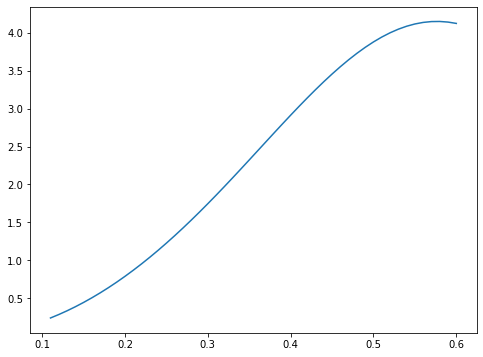

In [10]:
fig = plt.figure(figsize=(8, 6))
plt.plot(t[10:], msd_list[10:])
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [11]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

G = nx.from_numpy_array(abs(DSG_Hamiltonian(order, gamma)))
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.kamada_kawai_layout(G)

# vmin = 10**(1-order)
vmin = .5*10**(1-order)
vmax = 1.
mapper = ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)

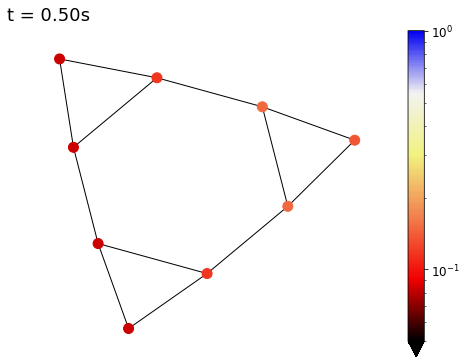

In [12]:
choose = 49

dpi = 72
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[choose]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % ((choose+1)*dt), fontsize=18)

plt.show()

In [9]:
import csv

with open(f'{folder}{name}_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [10]:
import pickle

with open(f'{folder}{name}_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [13]:
from matplotlib import animation

dpi = 300
playtime = 15
interval = int(playtime*1000/steps)
fps = int(steps/playtime)
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[0]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % 0., fontsize=18)

def animate(i):
    global nodes, time_text
    nodes.remove()
    time_text.remove()
    node_color = counts_list[i]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=mapper.to_rgba(node_color))
    time_text = ax.text(-1, 1, time_template % ((i+1)*dt), fontsize=18)
    return 0

ani = animation.FuncAnimation(fig, animate, frames=steps, interval=interval)

def progress_callback(i, n):
    print(f'Saving frame {i} of {n}', end='\r')
    return 0

writer = animation.writers['ffmpeg'](fps=fps)
ani.save(f'videos/{name}_animation.mp4', writer=writer, dpi=dpi, progress_callback=progress_callback)
del ani
plt.close(fig)
print(f'Saving frame {steps} of {steps} complete!')

Saving frame 60 of 60 complete!


In [6]:
def rw(order: int=3, gamma: float=1., t: float=1.) -> np.ndarray:
    
    H = DSG_Hamiltonian(order, gamma)
    size = len(H)
    psi0 = np.zeros(size)
    psi0[0] = 1

    return np.matmul(expm(-1*np.pi*H*t), psi0)

In [7]:
order = 4
steps = 1500
dt = .01
t = np.linspace(dt, steps*dt, steps)
gamma = 1.

folder = 'exact/'
name = f'o{order}_dsg_exrw_{steps*dt:.1f}s_{steps:d}vly'

In [8]:
counts_list = np.zeros_like(t, dtype=object)
per10 = steps/10

for i in range(steps):
    counts_list[i] = rw(order, gamma, t[i])
    if i%per10==0:
        print(f'{int(i/per10)*10}%', end='\r')
print(f'{100}% complete!')

100% complete!


In [9]:
msd_weight = DSG_MSD_weight(order)
msd_list = np.zeros_like(t, dtype=object)

for i in range(steps):
    msd_list[i] = (counts_list[i]*msd_weight).sum()

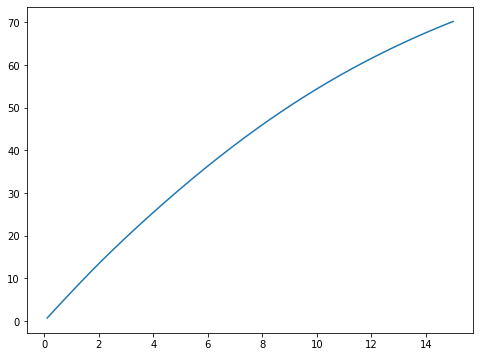

In [10]:
fig = plt.figure(figsize=(8, 6))
plt.plot(t[10:], msd_list[10:])
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [11]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

G = nx.from_numpy_array(abs(DSG_Hamiltonian(order, gamma)))
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.kamada_kawai_layout(G)

vmin = 10**(1-order)
vmax = 1.
mapper = ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)

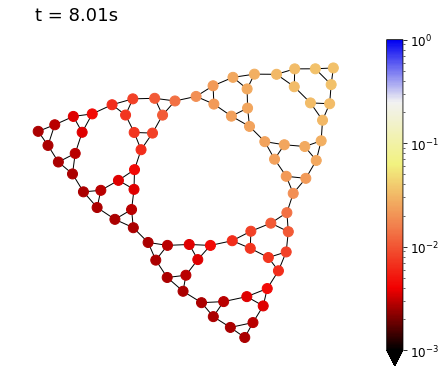

In [12]:
choose = 800

dpi = 72
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[choose]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % ((choose+1)*dt), fontsize=18)

plt.show()

In [13]:
import csv

with open(f'{folder}{name}_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [14]:
import pickle

with open(f'{folder}{name}_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [13]:
from matplotlib import animation

dpi = 300
playtime = 15
interval = int(playtime*1000/steps)
fps = int(steps/playtime)
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[0]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % 0., fontsize=18)

def animate(i):
    global nodes, time_text
    nodes.remove()
    time_text.remove()
    node_color = counts_list[i]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=mapper.to_rgba(node_color))
    time_text = ax.text(-1, 1, time_template % ((i+1)*dt), fontsize=18)
    return 0

ani = animation.FuncAnimation(fig, animate, frames=steps, interval=interval)

def progress_callback(i, n):
    print(f'Saving frame {i} of {n}', end='\r')
    return 0

writer = animation.writers['ffmpeg'](fps=fps)
ani.save(f'videos/{name}_animation.mp4', writer=writer, dpi=dpi, progress_callback=progress_callback)
del ani
plt.close(fig)
print(f'Saving frame {steps} of {steps} complete!')

Saving frame 1500 of 1500 complete!
